# In this notebook we will be experimenting different approaches to segment our plumes from the  static background 

###  The Matting Approach 


In [18]:
import cv2
import numpy as np
from pymatting import estimate_alpha_cf

def visualize_matting(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret: break
        frames.append(frame.astype(np.float64) / 255.0)
    cap.release()

    # Calculate Background
    background = np.median(np.stack(frames), axis=0)

    for i, frame in enumerate(frames):
        #  Automated Trimap Generation
        diff = np.abs(frame - background)
        diff_gray = np.max(diff, axis=2)
        
        h, w = diff_gray.shape
        trimap = np.full((h, w), 0.5, dtype=np.float64)
        trimap[diff_gray < 0.04] = 0.0  # Background
        trimap[diff_gray > 0.18] = 1.0  # Smoke Core

        #  Solve for Alpha
        alpha = estimate_alpha_cf(frame, trimap)

        #  Visualization 
        alpha_vis = cv2.cvtColor((alpha * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        trimap_vis = cv2.cvtColor((trimap * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        frame_vis = (frame * 255).astype(np.uint8)

        #Original  Trimap  Alpha]
        montage = np.hstack((frame_vis, trimap_vis, alpha_vis))

        cv2.imshow('Matting Visualization (Original | Trimap | Alpha)', montage)
        
        if cv2.waitKey(100) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

visualize_matting('/home/aoubaidi/Documents/Modelisation-panaches-de-fum-es-industrielles-par-Flow-Matching/data/videos/clairton1_2019-02-02_frame9716_96.mp4')

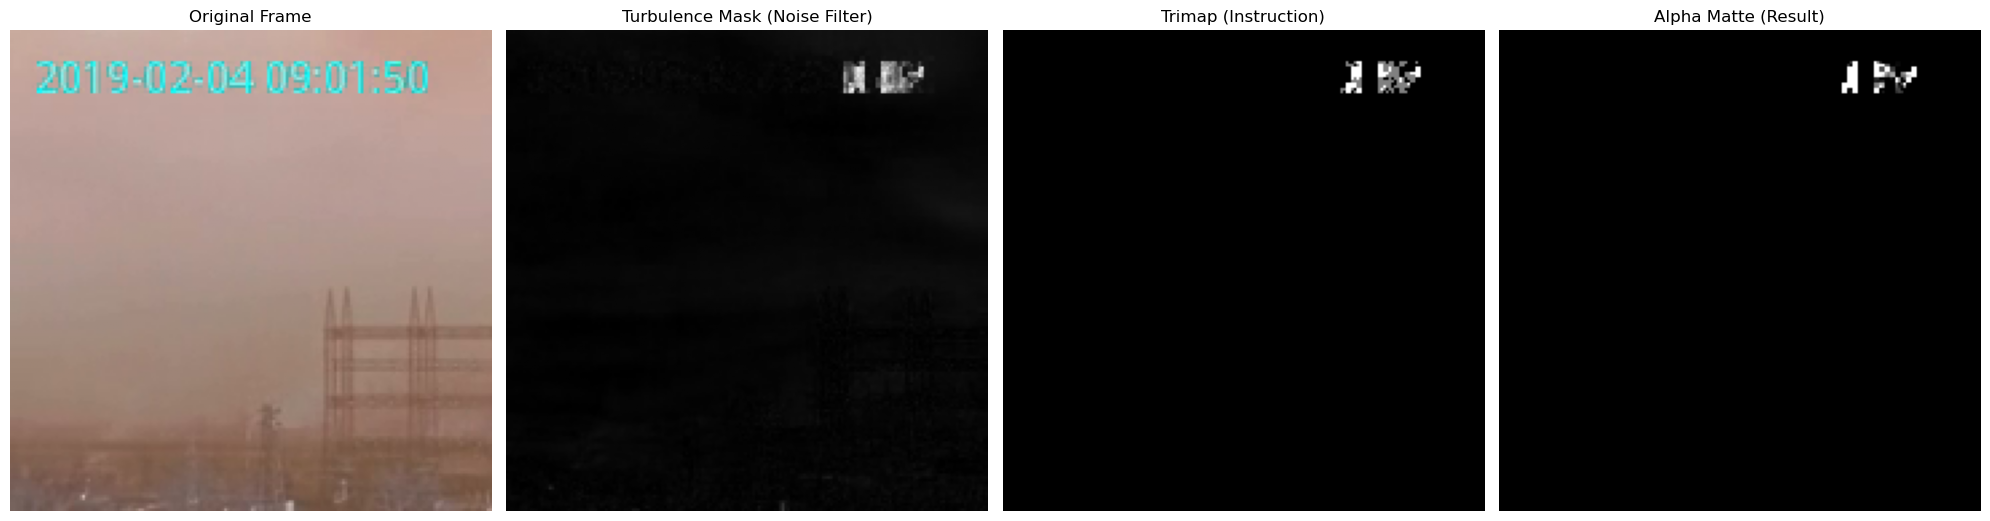

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pymatting import estimate_alpha_cf

def process_and_visualize_robust(video_path):
    # 1. LOAD THE SEQUENCE
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret: break
        frames.append(frame.astype(np.float64) / 255.0)
    cap.release()

    if not frames:
        print("Video not found or empty.")
        return

    # Convert list to 4D array (Time, Height, Width, Channels)
    video_stack = np.stack(frames)
    
    # CALCULATE BACKGROUND 
    # Median handles static background
    background = np.median(video_stack, axis=0)
    # Standard Deviation handles clouds/fog 
    variance = np.std(video_stack, axis=0)
    turbulence_mask = np.max(variance, axis=2) # Take max variance across RGB
    # Normalize turbulence for visualization
    turbulence_norm = cv2.normalize(turbulence_mask, None, 0, 1, cv2.NORM_MINMAX)

    #SELECT A TEST FRAME (middle of the clip)
    test_idx = len(frames) // 2
    frame = frames[test_idx]

    # GENERATE  TRIMAP

    diff = np.abs(frame - background)
    diff_gray = np.max(diff, axis=2)

    #  High color change AND High turbulence = Smoke
    smoke_score = diff_gray * turbulence_norm
    
    h, w = diff_gray.shape
    trimap = np.full((h, w), 0.5, dtype=np.float64)
    
    # Thresholding the combined score
    trimap[smoke_score < 0.02] = 0.0   
    trimap[smoke_score > 0.12] = 1.0   

    #SOLVE FOR ALPHA MATTE
    try:
        alpha = estimate_alpha_cf(frame, trimap)
    except Exception as e:
        print(f"Matting Error: {e}")
        alpha = np.zeros_like(diff_gray)

    plt.figure(figsize=(20, 10))
    
    titles = ['Original Frame', 'Turbulence Mask (Noise Filter)', 'Trimap (Instruction)', 'Alpha Matte (Result)']
    images = [frame, turbulence_norm, trimap, alpha]
    
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(images[i], cmap='gray' if i > 0 else None)
        plt.title(titles[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

video_path = '/home/aoubaidi/Documents/Modelisation-panaches-de-fum-es-industrielles-par-Flow-Matching/data/videos/clairton1_2019-02-04_frame4552_132.mp4'
process_and_visualize_robust(video_path)